In [255]:
import math
import torch
import gpytorch
import seaborn as sns
import numpy as np
from control import *
from matplotlib import pyplot as plt
from IPython.display import display
from tqdm import tqdm


sns.set_theme(style="darkgrid")

%matplotlib inline
%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Generate State Space Training Data

torch.Size([10, 1])

torch.Size([10, 6])

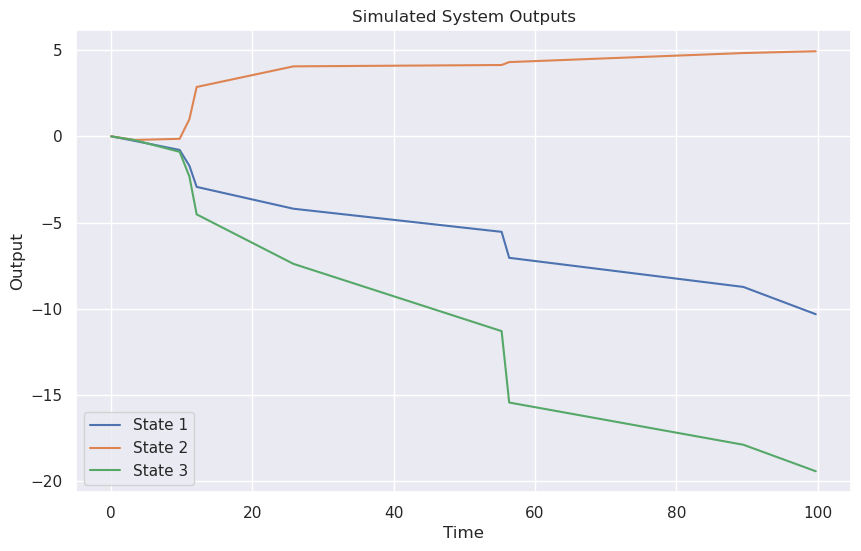

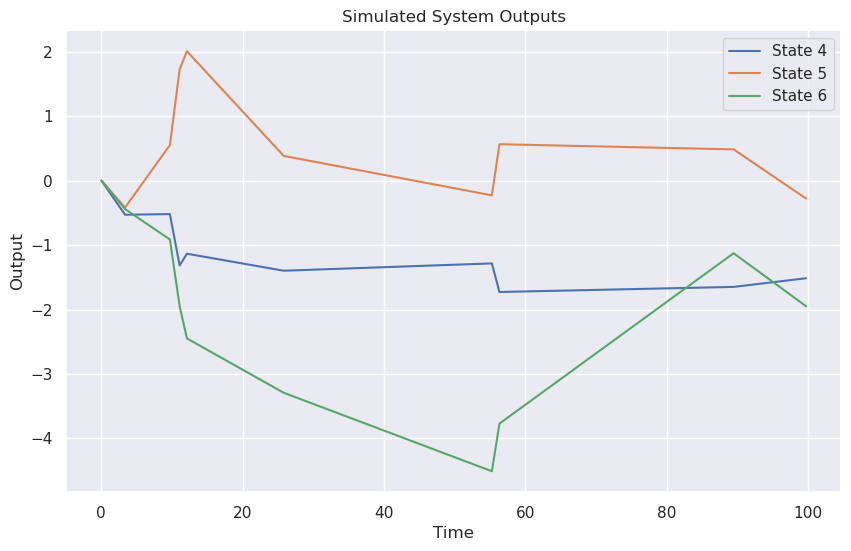

In [256]:
# Create SS Model
m=1.0
I=1.0
q=1.0
r=1.0
dt=1.0

M = np.diag([m, m, I])
A = np.zeros((6, 6))
A[0:3, 3:6] = np.eye(3)
B = np.zeros((6, 3))
B[3:6, 0:3] = np.diag([1/m, 1/m, 1/I])
C = np.eye(6)
D = np.zeros((6, 3))
sys = ss(A, B, C, D)
# print(sys)
# Discretize the system
sysd = c2d(sys, Ts=dt)
# print(sysd)

# t = np.linspace(0, 100, num=100)
t = np.sort(np.random.uniform(0, 100, size=10))  # Generate random time points and sort them

# Generate state-space dataset
X = t.reshape(-1, 1)  # Input is time
Y = []

# Initial state
x = np.zeros((6, 1))
for time in t:
    # Simulate the state-space model
    x_kp1 = sysd.A @ x + sysd.B @ (1 * np.random.randn(3, 1))  # Random input for simulation
    # print(x_kp1)
    y_k = sysd.C @ x + sysd.D @ np.random.randn(3, 1)  # Measurement with noise
    Y.append(y_k.flatten())
    
    x = x_kp1  # Update state for next iteration

Y = np.array(Y)  # Output is 6D measurement

# print(f"X: {X.shape}")
# print(f"Y: {Y.shape}")

# Define train data
train_x = torch.from_numpy(X).float().to(device)
train_y = torch.from_numpy(Y).float().to(device)

display(train_x.size())
display(train_y.size())

plt.figure(figsize=(10, 6))
for state in range(3):
    plt.plot(X, Y[:, state], label=f'State {state + 1}')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Simulated System Outputs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for state in range(3,6):
    plt.plot(X, Y[:, state], label=f'State {state + 1}')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Simulated System Outputs')
plt.legend()
plt.show()



In [257]:
print(f"train_x is on: {train_x.device}")


train_x is on: cuda:0


# Setup up GP Model & Likelihood function

In [258]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class MultiOutputGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, train_x, num_outputs, num_latents=1):
        # Use a variational strategy for multi-output regression
        inducing_points = train_x[:100].repeat(num_outputs, 1, 1)
        print(f"Inducing points shape: {inducing_points.shape}")
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
            ),
            num_tasks=num_outputs,
            num_latents=num_latents
        )
        super(MultiOutputGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_outputs]))
        # self.covar_module = gpytorch.kernels.ScaleKernel(
        #     gpytorch.kernels.Kernel(batch_shape=torch.Size([num_outputs])),
        #     batch_shape=torch.Size([num_outputs])
        # )
        self.covar_module = gpytorch.kernels.MultitaskKernel(gpytorch.kernels.RBFKernel(), num_tasks=num_outputs, rank=1)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class MultiOutputExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_outputs):
        super(MultiOutputExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.num_outputs = num_outputs

        # Define a mean module for multitask GPs
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_outputs
        )

        # Define a covariance module for multitask GPs
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_outputs, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    
# Initialize likelihood and model for multi-output regression
num_outputs = train_y.size(-1)
print(f"Number of outputs: {num_outputs}")
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs, noise_prior=gpytorch.priors.NormalPrior(loc=0.5, scale=2.0))
likelihood.noise = torch.tensor(0.5).to(device)  # Set noise to a fixed value
model = MultiOutputExactGPModel(train_x, train_y, likelihood, num_outputs)


Number of outputs: 6


# Train Model

In [259]:
training_iter = 1000

# Move model and likelihood to GPU
model = model.to(device)
likelihood = likelihood.to(device)

# Find optimal model hyperparameters
model.train()
likelihood.train()


# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in tqdm(range(training_iter), desc="Training Progress"):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if (i + 1) % 100 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.data_covar_module.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

Training Progress:  14%|█▍        | 138/1000 [00:00<00:03, 226.17it/s]

Iter 100/1000 - Loss: 1.780   lengthscale: 2.698   noise: 0.342


Training Progress:  23%|██▎       | 230/1000 [00:01<00:03, 224.36it/s]

Iter 200/1000 - Loss: 1.550   lengthscale: 2.977   noise: 0.073


Training Progress:  32%|███▏      | 324/1000 [00:01<00:02, 227.53it/s]

Iter 300/1000 - Loss: 1.489   lengthscale: 3.429   noise: 0.071


Training Progress:  43%|████▎     | 426/1000 [00:01<00:02, 243.60it/s]

Iter 400/1000 - Loss: 1.435   lengthscale: 3.436   noise: 0.041


Training Progress:  52%|█████▏    | 523/1000 [00:02<00:02, 228.35it/s]

Iter 500/1000 - Loss: 1.407   lengthscale: 3.303   noise: 0.017


Training Progress:  64%|██████▍   | 638/1000 [00:02<00:01, 221.96it/s]

Iter 600/1000 - Loss: 1.401   lengthscale: 3.318   noise: 0.011


Training Progress:  74%|███████▎  | 736/1000 [00:03<00:01, 226.86it/s]

Iter 700/1000 - Loss: 1.399   lengthscale: 3.381   noise: 0.008


Training Progress:  83%|████████▎ | 828/1000 [00:03<00:00, 220.98it/s]

Iter 800/1000 - Loss: 1.397   lengthscale: 3.528   noise: 0.006


Training Progress:  94%|█████████▍| 943/1000 [00:04<00:00, 223.76it/s]

Iter 900/1000 - Loss: 1.394   lengthscale: 4.027   noise: 0.005


Training Progress: 100%|██████████| 1000/1000 [00:04<00:00, 226.31it/s]

Iter 1000/1000 - Loss: 1.393   lengthscale: 4.088   noise: 0.004


## Make predictions with the model

In [260]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions
    test_x = torch.linspace(0, 100, 100).reshape(-1, 1).float().to(device)
    observed_pred = likelihood(model(test_x))

## Plot Model Fit

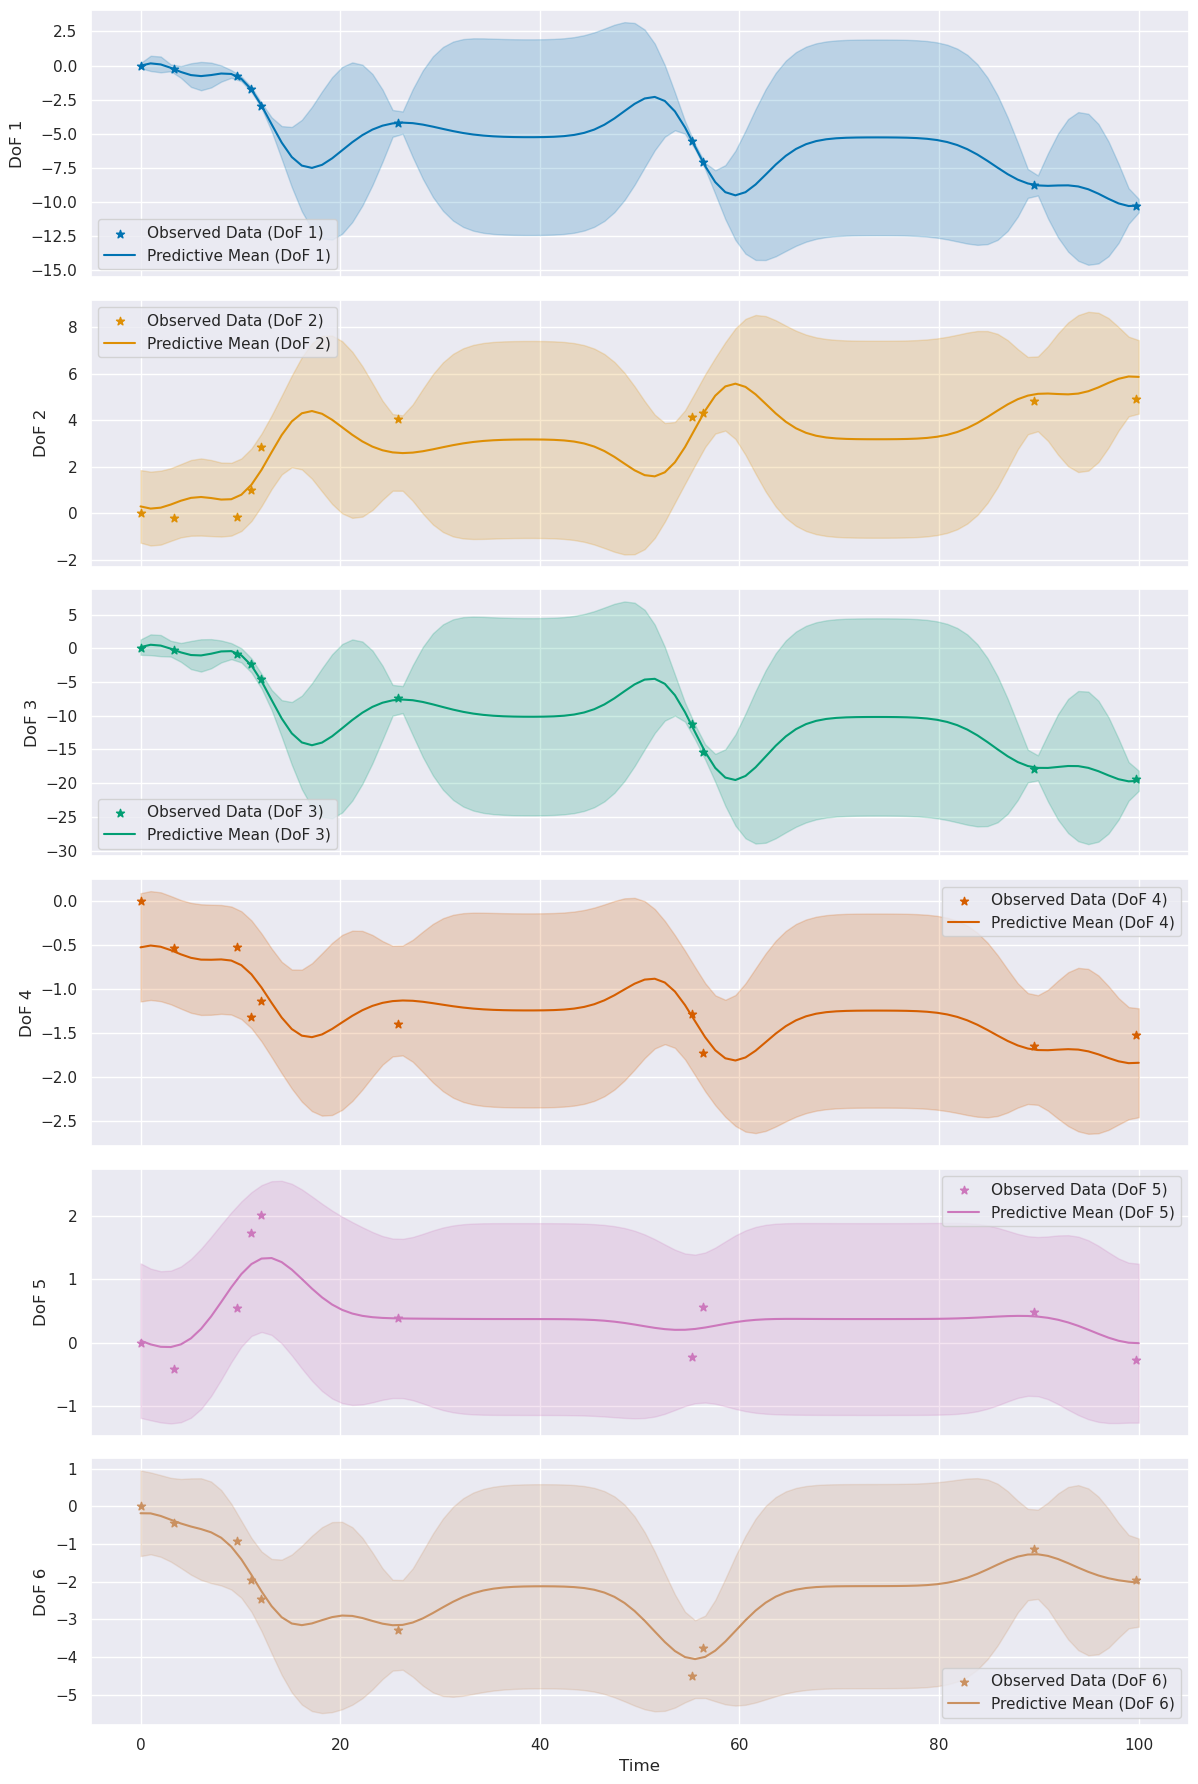

In [261]:
# Define a colormap for each state
colormap = sns.color_palette("colorblind", 6)

with torch.no_grad():
    # Initialize plot with 6 subplots
    f, axes = plt.subplots(6, 1, figsize=(12, 18), sharex=True)

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()

    # Plot predictive means and confidence bounds for each degree of freedom
    for i in range(6):
        ax = axes[i]
        # Plot training data as black stars
        ax.scatter(train_x.cpu().numpy().flatten(), train_y.cpu().numpy()[:, i], label=f"Observed Data (DoF {i + 1})", color=colormap[i], marker='*')
        # Plot predictive means
        ax.plot(test_x.cpu().numpy().flatten(), observed_pred.mean[:, i].cpu().numpy(), label=f'Predictive Mean (DoF {i + 1})', color=colormap[i])
        # Plot confidence bounds
        ax.fill_between(test_x.cpu().numpy().flatten(), lower[:, i].cpu().numpy(), upper[:, i].cpu().numpy(), color=colormap[i], alpha=0.2)
        ax.set_ylabel(f'DoF {i + 1}')
        ax.legend()

    # Set common x-label
    axes[-1].set_xlabel('Time')
    plt.tight_layout()
    plt.show()


In [265]:
# Print kernel parameters
print("Kernel Parameters:")
print(f"Lengthscale: {model.covar_module.data_covar_module.lengthscale}")
# Print the task covariance matrix explicitly
print(f"Task Covariance Matrix (explicit):\n{model.covar_module.task_covar_module.covar_matrix.to_dense()}")

Kernel Parameters:
Lengthscale: tensor([[4.0890]], device='cuda:0', grad_fn=<SoftplusBackward0>)
Task Covariance Matrix (explicit):
tensor([[ 1.2851e+01, -7.0537e+00,  2.6082e+01,  1.6386e+00,  9.5739e-02,
          1.4095e+00],
        [-7.0537e+00,  3.8819e+00, -1.4345e+01, -9.0118e-01, -5.2655e-02,
         -7.7520e-01],
        [ 2.6082e+01, -1.4345e+01,  5.3365e+01,  3.3323e+00,  1.9470e-01,
          2.8664e+00],
        [ 1.6386e+00, -9.0118e-01,  3.3323e+00,  2.1734e-01,  1.2232e-02,
          1.8008e-01],
        [ 9.5739e-02, -5.2655e-02,  1.9470e-01,  1.2232e-02,  3.2040e-01,
          1.0522e-02],
        [ 1.4095e+00, -7.7520e-01,  2.8664e+00,  1.8008e-01,  1.0522e-02,
          1.6579e+00]], device='cuda:0', grad_fn=<AddBackward0>)
